In [3]:
import kagglehub

path = kagglehub.dataset_download("co1d7era/mixedtype-wafer-defect-datasets")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mixedtype-wafer-defect-datasets


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
pip install iterative-stratification

Note: you may need to restart the kernel to use updated packages.


In [6]:
numpy_file=np.load('/kaggle/input/mixedtype-wafer-defect-datasets/Wafer_Map_Datasets.npz')

In [7]:
X=numpy_file['arr_0']
Y=numpy_file['arr_1']

In [8]:
X.shape

(38015, 52, 52)

*   Total datapoint=38015 (non-null)


**We have class imbalance. So, we have to maintain same distribution between val and test. So I will use MultilabelStratifiedShuffleSplit library to maintain same distribution between all three splits.**

In [9]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np

split1 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
train_val_idx, test_idx = next(split1.split(X, Y))
X_train_val, Y_train_val = X[train_val_idx], Y[train_val_idx]
X_test, Y_test = X[test_idx], Y[test_idx]

In [10]:
split2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.176, random_state=42)
train_idx, val_idx = next(split2.split(X_train_val, Y_train_val))
X_train, Y_train = X_train_val[train_idx], Y_train_val[train_idx]
X_val, Y_val = X_train_val[val_idx], Y_train_val[val_idx]

In [11]:
print(f"""{Y_train.sum(axis=0)}
{Y_test.sum(axis=0)}
{Y_val.sum(axis=0)}""")

[ 9105  8405  9105  8405 12607   105 13308   606]
[1950 1800 1950 1800 2700   22 2850  130]
[1945 1795 1945 1795 2693   22 2842  130]


In [12]:
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

In [13]:
X_train.shape[0]

26625

In [14]:
input_shape=X_train.shape[1:]

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Sequential
model = Sequential([
    keras.Input(shape=input_shape),

    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(8, activation='sigmoid')
])

I0000 00:00:1753796137.779454      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753796137.780234      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 23, 23, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 23, 23, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,012,104 (3.86 MB)

 Trainable params: 1,011,656 (3.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
batch_size = 128
epochs = 200
model.compile(
    optimizer="adam",
    loss=keras.losses.BinaryCrossentropy()
)

**This is image-like binary data that considers spatial dimensions, where the relative positions of elements can determine the defect pattern. So, I’ll go with data augmentation.**

In [19]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, Y_val),
)

Epoch 1/200


I0000 00:00:1753796145.905206     105 service.cc:148] XLA service 0x7fee3c002280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753796145.906127     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753796145.906151     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753796146.373317     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


 14/209 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.7431

I0000 00:00:1753796150.256922     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


209/209 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.4502 - val_loss: 1.4847
Epoch 2/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1000 - val_loss: 1.0159
Epoch 3/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0612 - val_loss: 0.2387
Epoch 4/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0445 - val_loss: 0.1829
Epoch 5/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0373 - val_loss: 0.0362
Epoch 6/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0318 - val_loss: 0.1014
Epoch 7/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0272 - val_loss: 0.0510
Epoch 8/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0245 - val_loss: 0.0375
Epoch 9/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0210 - val_loss: 0.0320
Epoch 10/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0188 - val_loss: 0.0300
Epoch 11/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0186 - val_loss: 0.0312
Epoch 12/200
209/209 ━━━━━━━━━━━━━━━━━━━━

In [20]:
model_train_data=pd.DataFrame(history.history)

In [21]:
model_train_data[-10:]

,loss,val_loss
190,0.001264,0.045646
191,0.001432,0.035450
192,0.001258,0.041841
193,0.001332,0.057051
194,0.001060,0.041273
195,0.001242,0.042713
196,0.001381,0.044348
197,0.001278,0.056373
198,0.001064,0.038070
199,0.001729,0.050753


<Axes: >

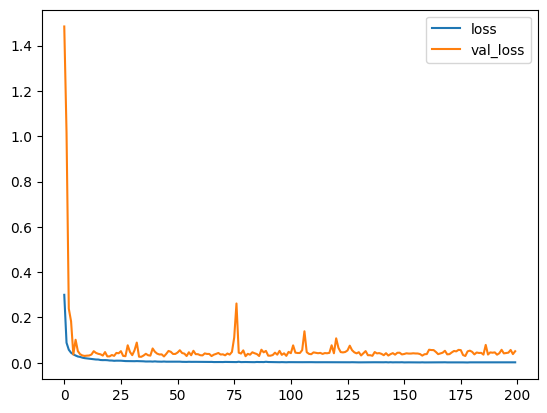

In [22]:
model_train_data['loss'].plot(legend="Training Loss")
model_train_data['val_loss'].plot(legend="Val Loss")

**There is some noise in the training loss, which is expected due to dropout and mini-batch gradient descent. The validation loss, however, exhibits much more fluctuation. Let’s evaluate whether there is an overall downward trend.**

In [23]:
val_loss=model_train_data['val_loss']
epochs = np.arange(len(val_loss))
slope, intercept = np.polyfit(epochs, val_loss, 1)

print(f"Loss slope over epochs: {slope:.6f}")

if slope < 0:
    print("Overall validation loss is decreasing.")
else:
    print("Validation loss is not decreasing.")

Loss slope over epochs: -0.000392
Overall validation loss is decreasing.


In [24]:
results = model.evaluate(X_test, Y_test)
print("Test loss is", results)

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0664
Test loss is 0.055768512189388275


In [25]:
from sklearn.metrics import classification_report
y_pred=model.predict(X_test)
y_pred=(y_pred>0.5)
print(classification_report(Y_test,y_pred))

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1950
           1       1.00      1.00      1.00      1800
           2       1.00      0.94      0.97      1950
           3       0.96      1.00      0.98      1800
           4       1.00      0.98      0.99      2700
           5       1.00      0.82      0.90        22
           6       0.98      1.00      0.99      2850
           7       0.99      1.00      1.00       130

   micro avg       0.99      0.99      0.99     13202
   macro avg       0.99      0.97      0.98     13202
weighted avg       0.99      0.99      0.99     13202
 samples avg       0.96      0.96      0.96     13202



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
from sklearn.metrics import multilabel_confusion_matrix

conf_matrices = multilabel_confusion_matrix(Y_test, y_pred)

In [27]:
conf_matrices

array([[[3753,    0],
        [   0, 1950]],

       [[3903,    0],
        [   0, 1800]],

       [[3747,    6],
        [ 110, 1840]],

       [[3833,   70],
        [   2, 1798]],

       [[2996,    7],
        [  51, 2649]],

       [[5681,    0],
        [   4,   18]],

       [[2794,   59],
        [   9, 2841]],

       [[5572,    1],
        [   0,  130]]])

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


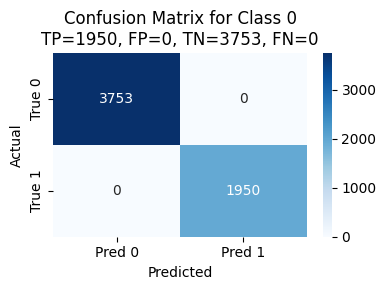

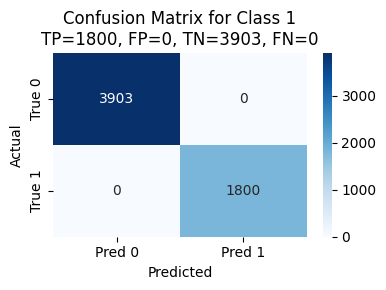

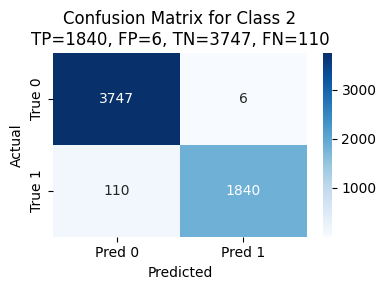

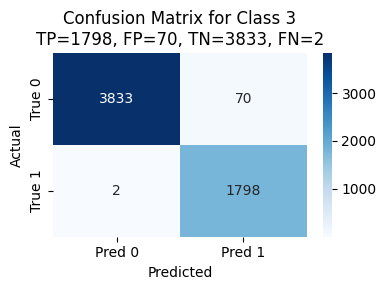

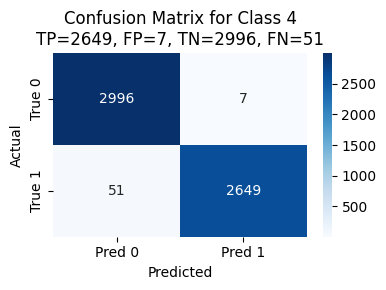

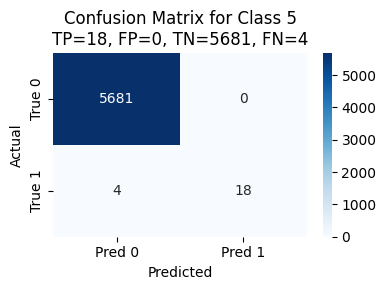

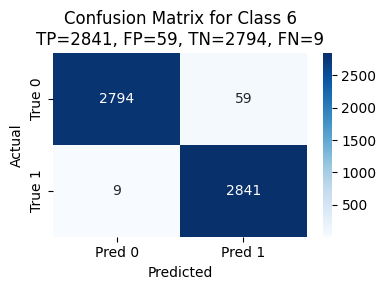

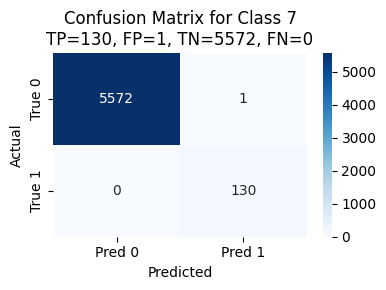

In [28]:
import seaborn as sns
class_names = ["Center","Donut","Edge_local","Edge_ring","near_full","scratch","random"]
y_pred = (model.predict(X_test) > 0.5)
conf_matrices = multilabel_confusion_matrix(Y_test, y_pred)
class_names = [f"Class {i}" for i in range(conf_matrices.shape[0])]
for i, cm in enumerate(conf_matrices):
    tn, fp, fn, tp = cm.ravel()
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"])
    plt.title(f"Confusion Matrix for {class_names[i]}\nTP={tp}, FP={fp}, TN={tn}, FN={fn}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

In [29]:
normal_pred = (y_pred.sum(axis=1) == 0)
normal_true = (Y_test.sum(axis=1) == 0)

In [42]:
from sklearn.metrics import confusion_matrix
cm_normal = confusion_matrix(normal_true, normal_pred)

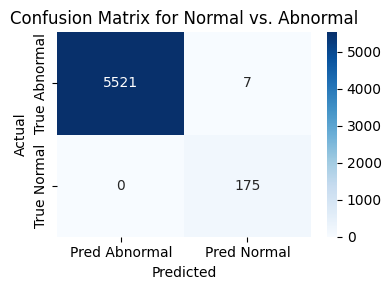

In [31]:
plt.figure(figsize=(4, 3))
sns.heatmap(cm_normal, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Abnormal", "Pred Normal"], yticklabels=["True Abnormal", "True Normal"])
plt.title("Confusion Matrix for Normal vs. Abnormal")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

### We have to tune the model for this. After tuning, we have to do error analysis based on test set as follows.

In [32]:
# model.save('cnn.h5')

In [36]:
print("Hello")

Hello


In [34]:
error_matrix = {}

for i in range(len(conf_matrices)):
    np.fill_diagonal(conf_matrices[i], 0)
    error_count = conf_matrices[i].sum()
    error_matrix[class_names[i]] = error_count

In [45]:
cm_normal.diagonal()

array([5521,  175])

In [46]:
np.fill_diagonal(cm_normal,0)

In [47]:
cm_normal.sum()

7

In [49]:
error_matrix['Normal']=cm_normal.sum()

In [50]:
error_matrix

{'Class 0': 0,
 'Class 1': 0,
 'Class 2': 116,
 'Class 3': 72,
 'Class 4': 58,
 'Class 5': 4,
 'Class 6': 68,
 'Class 7': 1,
 'Normal': 7}

In error analysis, we should address Class 2, which is Edge_local and has the highest misclassification count.